In [7]:
# ===================================================================================
# SECTION 1: SETUP AND DATA LOADING
# ===================================================================================

# Initiate the venv setup: 
# 1) Press Ctrl + Shift + P, 
# 2) Select the Interpreter: A search bar will appear. Start typing "Python: Select Interpreter" and press Enter when it appears.
# 3) Choose Your Virtual Environment: VS Code will automatically scan your project folder and find your venv.
# 4) It might also be marked as "Recommended". Click on it.
# 5) Simply open a new terminal: Go to the top menu: Terminal -> New Terminal.
# 6) If this fails, run this code: .\venv\Scripts\Activate.ps1 in powershell terminal.


# Core libraries
import numpy as np
import os
import pandas as pd
import gc  # Garbage collection for memory management
import time
from contextlib import contextmanager

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Pandas display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# A simple timer function to measure the execution time of code blocks
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print(f"{title} - done in {time.time() - t0:.0f}s")
    
print("Setup complete. Libraries imported and timer function defined.")

# ===================================================================================
# Load all necessary datasets
# ===================================================================================

# Update this path to where your data is stored.
DATA_PATH = r"C:\Users\Christina\Dropbox\PERSONAL\YUVARAJ\PROJECTS\credit_risk_major\data"
print("Loading raw data files using os.path.join...")

with timer("Data Loading"):
    train_path = os.path.join(DATA_PATH, 'application_train.csv')
    bureau_path = os.path.join(DATA_PATH, 'bureau.csv')
    bureau_balance_path = os.path.join(DATA_PATH, 'bureau_balance.csv')
    previous_app_path = os.path.join(DATA_PATH, 'previous_application.csv')
    pos_cash_path = os.path.join(DATA_PATH, 'POS_CASH_balance.csv')
    installments_path = os.path.join(DATA_PATH, 'installments_payments.csv')
    credit_card_path = os.path.join(DATA_PATH, 'credit_card_balance.csv')

# Load the dataframes
    df_train = pd.read_csv(train_path)
    df_bureau = pd.read_csv(bureau_path)
    df_bureau_balance = pd.read_csv(bureau_balance_path)
    df_previous_app = pd.read_csv(previous_app_path)
    df_pos_cash = pd.read_csv(pos_cash_path)
    df_installments = pd.read_csv(installments_path)
    df_credit_card = pd.read_csv(credit_card_path)
    
# Store original shapes for verification
    original_shapes = {
        'train': df_train.shape,
        'bureau': df_bureau.shape,
        'bureau_balance': df_bureau_balance.shape,
        'previous_app': df_previous_app.shape,
        'pos_cash': df_pos_cash.shape,
        'installments': df_installments.shape,
        'credit_card': df_credit_card.shape
    }

    print("\nData loading complete.")
    print("Original shapes of loaded dataframes:")
    for name, shape in original_shapes.items():
        print(f"- {name}: {shape}")




Setup complete. Libraries imported and timer function defined.
Loading raw data files using os.path.join...

Data loading complete.
Original shapes of loaded dataframes:
- train: (307511, 122)
- bureau: (1716428, 17)
- bureau_balance: (27299925, 3)
- previous_app: (1670214, 37)
- pos_cash: (10001358, 8)
- installments: (13605401, 8)
- credit_card: (3840312, 23)
Data Loading - done in 71s


In [12]:
# ===================================================================================
# It systematically processes all external files, displays a presentation-grade
# report in the notebook, and saves a clean, auditable CSV artifact.
# ===================================================================================


# -----------------------------------------------------------------------------------
# STEP 1: DEFINE OUR DEFINITIVE, PRESENTATION-GRADE PROFILING TOOL
# -----------------------------------------------------------------------------------
def data_profiling_report(df: pd.DataFrame, df_name: str = "", unique_value_threshold: int = 15) -> pd.DataFrame:
    """
    Generates and displays a definitive, presentation-grade data profiling report.

    Args:
        df (pd.DataFrame): The DataFrame to be profiled.
        df_name (str, optional): The name of the DataFrame for the report title. Defaults to "".
        
        unique_value_threshold (int, optional): The maximum number of unique values to display. 
        Above this, it will be marked as high cardinality. 
        Defaults to 15.

    Returns:
        pd.DataFrame: A polished data profiling report.
    """
    if df_name:
        print(f"--- Definitive Data Profiling Report for: {df_name} ---")
        print(f"Shape of DataFrame: {df.shape}\n")
    
    # Perform all calculations.
    summary_stats = df.describe(include='all').T
    info_df = pd.DataFrame({
        'Data Type': df.dtypes,
        '% Missing': df.isnull().sum() / len(df) * 100,
    
    })
    final_report = summary_stats.join(info_df)

    #Coefficient of Variation to check extreme skewness in distribtion (outliers)
    # Calculate only for numerical columns where mean is not zero to avoid division errors

    final_report['Coeff of Var'] = final_report.apply(
        lambda row: abs(row['std'] / row['mean']) if pd.notnull(row['mean']) and row['mean'] != 0 else np.nan,
        axis=1
    )

    # Add values of Unique categorical entries
    unique_entries = {}
    for col in df.columns:
        # Check if the column is categorical (category dtype/object)
        if isinstance(df[col].dtype, pd.CategoricalDtype) or df[col].dtype == 'object':
            # Check if the number of unique values is within our threshold
            if final_report.loc[col, 'unique'] <= unique_value_threshold:
                # Get the unique values and convert to a list for clean display
                unique_entries[col] = df[col].unique().tolist()
            else:
                # If cardinality is too high, mark it to avoid clutter
                unique_entries[col] = "[High Cardinality]"
        else:
            # For numerical columns, leave it blank
            unique_entries[col] = np.nan
            
    # Add the new series as the last column of our report
    final_report['Unique Values'] = pd.Series(unique_entries)
    
    # Final cleanup and reordering
    if '50%' in final_report.columns:
        final_report.rename(columns={'50%': 'Median (50%)'}, inplace=True)
        
    # Ensure the '# Unique' column is last, and reorder the core columns to the front
    core_cols = ['Data Type', '% Missing']
    # The new 'Unique Values' column is handled separately to ensure it's at the end
    stat_cols = [col for col in final_report.columns if col not in core_cols and col != 'Unique Values']
    
    final_report = final_report[core_cols + stat_cols + ['Unique Values']]
    
    # Sort by the most critical metric
    return final_report.sort_values(by='% Missing', ascending=False)

# -----------------------------------------------------------------------------------
# STEP 2: DEFINE FILE PATHS AND OUTPUT DIRECTORY
# -----------------------------------------------------------------------------------
# Base path to the raw data
DATA_PATH = r"C:\Users\Christina\Dropbox\PERSONAL\YUVARAJ\PROJECTS\credit_risk_major\data"
# Path for our output reports
REPORTS_PATH = os.path.join("..", "outputs", "reports")
# Safely create the reports directory if it doesn't exist
os.makedirs(REPORTS_PATH, exist_ok=True)
print(f"Reports will be saved to: {os.path.abspath(REPORTS_PATH)}")

# List of the external files we want to profile
files_to_profile = [
    'bureau.csv',
    'bureau_balance.csv',
    'previous_application.csv',
    'POS_CASH_balance.csv',
    'installments_payments.csv',
    'credit_card_balance.csv'
]

# -----------------------------------------------------------------------------------
# STEP 3: EXECUTE THE AUTOMATED PROFILING AND SAVING LOOP
# -----------------------------------------------------------------------------------
print("\nStarting automated data profiling with performance monitoring...\n")

for filename in files_to_profile:
    # NEW: Start the timer for the entire processing of one file
    with timer(f"Processing '{filename}'"):
        try:
            file_path = os.path.join(DATA_PATH, filename)
            df = pd.read_csv(file_path)
            print("Loading complete. Generating report...")
            
            report_df = data_profiling_report(df, df_name=filename)
            
            # Display the raw report in the notebook
            display(report_df)
                        
            output_filename = f"{os.path.splitext(filename)[0]}_profiling_report.csv"
            output_path = os.path.join(REPORTS_PATH, output_filename)
            
            report_df.to_csv(output_path, index=True)
            
            print(f"\nSUCCESS: Report for '{filename}' saved to '{output_path}'")
            print("-" * 80 + "\n")

            # --- NEW: EXPLICIT MEMORY CLEANUP ---
            # This block runs at the end of each successful iteration.
            print("Cleaning up memory...")
            del df, report_df
            gc.collect()

        except FileNotFoundError:
            print(f"ERROR: The file '{filename}' was not found at '{file_path}'. Please check the path.\n")
        except Exception as e:
            print(f"ERROR: An unexpected error occurred while processing '{filename}': {e}\n")

print("Automated data profiling complete.")

Reports will be saved to: c:\Users\Christina\Dropbox\PERSONAL\YUVARAJ\PROJECTS\credit_risk_major\outputs\reports

Starting automated data profiling with performance monitoring...

Loading complete. Generating report...
--- Definitive Data Profiling Report for: bureau.csv ---
Shape of DataFrame: (1716428, 17)



,Data Type,% Missing,count,unique,top,freq,mean,std,min,25%,Median (50%),75%,max,Coeff of Var,Unique Values
AMT_ANNUITY,float64,71.473490,489637.0,NaN,NaN,NaN,15712.7577,325826.949053,0.0,0.0,0.0,13500.0,118453423.5,20.736459,NaN
AMT_CREDIT_MAX_OVERDUE,float64,65.513264,591940.0,NaN,NaN,NaN,3825.417661,206031.606207,0.0,0.0,0.0,0.0,115987185.0,53.858591,NaN
DAYS_ENDDATE_FACT,float64,36.916958,1082775.0,NaN,NaN,NaN,-1017.437148,714.010626,-42023.0,-1489.0,-897.0,-425.0,0.0,0.701774,NaN
AMT_CREDIT_SUM_LIMIT,float64,34.477415,1124648.0,NaN,NaN,NaN,6229.51498,45032.031476,-586406.115,0.0,0.0,0.0,4705600.32,7.228818,NaN
AMT_CREDIT_SUM_DEBT,float64,15.011932,1458759.0,NaN,NaN,NaN,137085.119952,677401.130952,-4705600.32,0.0,0.0,40153.5,170100000.0,4.941464,NaN
DAYS_CREDIT_ENDDATE,float64,6.149573,1610875.0,NaN,NaN,NaN,510.517362,4994.219837,-42060.0,-1138.0,-330.0,474.0,31199.0,9.782664,NaN
AMT_CREDIT_SUM,float64,0.000757,1716415.0,NaN,NaN,NaN,354994.591918,1149811.34398,0.0,51300.0,125518.5,315000.0,585000000.0,3.238955,NaN
CREDIT_ACTIVE,object,0.000000,1716428,4,Closed,1079273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Closed, Active, Sold, Bad debt]"
CREDIT_CURRENCY,object,0.000000,1716428,4,currency 1,1715020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[currency 1, currency 2, currency 4, currency 3]"
DAYS_CREDIT,int64,0.000000,1716428.0,NaN,NaN,NaN,-1142.107685,795.164928,-2922.0,-1666.0,-987.0,-474.0,0.0,0.696226,NaN



SUCCESS: Report for 'bureau.csv' saved to '..\outputs\reports\bureau_profiling_report.csv'
--------------------------------------------------------------------------------

Cleaning up memory...
Processing 'bureau.csv' - done in 24s
Loading complete. Generating report...
--- Definitive Data Profiling Report for: bureau_balance.csv ---
Shape of DataFrame: (27299925, 3)



,Data Type,% Missing,count,unique,top,freq,mean,std,min,25%,Median (50%),75%,max,Coeff of Var,Unique Values
SK_ID_BUREAU,int64,0.0,27299925.0,NaN,NaN,NaN,6036297.332974,492348.856904,5001709.0,5730933.0,6070821.0,6431951.0,6842888.0,0.081565,NaN
MONTHS_BALANCE,int64,0.0,27299925.0,NaN,NaN,NaN,-30.741687,23.864509,-96.0,-46.0,-25.0,-11.0,0.0,0.776291,NaN
STATUS,object,0.0,27299925,8,C,13646993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[C, 0, X, 1, 2, 3, 5, 4]"



SUCCESS: Report for 'bureau_balance.csv' saved to '..\outputs\reports\bureau_balance_profiling_report.csv'
--------------------------------------------------------------------------------

Cleaning up memory...
Processing 'bureau_balance.csv' - done in 45s
Loading complete. Generating report...
--- Definitive Data Profiling Report for: previous_application.csv ---
Shape of DataFrame: (1670214, 37)



,Data Type,% Missing,count,unique,top,freq,mean,std,min,25%,Median (50%),75%,max,Coeff of Var,Unique Values
RATE_INTEREST_PRIVILEGED,float64,99.643698,5951.0,NaN,NaN,NaN,0.773503,0.100879,0.37315,0.715645,0.835095,0.852537,1.0,0.130418,NaN
RATE_INTEREST_PRIMARY,float64,99.643698,5951.0,NaN,NaN,NaN,0.188357,0.087671,0.034781,0.160716,0.189122,0.19333,1.0,0.465452,NaN
AMT_DOWN_PAYMENT,float64,53.636480,774370.0,NaN,NaN,NaN,6697.402139,20921.49541,-0.9,0.0,1638.0,7740.0,3060045.0,3.123822,NaN
RATE_DOWN_PAYMENT,float64,53.636480,774370.0,NaN,NaN,NaN,0.079637,0.107823,-0.000015,0.0,0.051605,0.108909,1.0,1.353938,NaN
NAME_TYPE_SUITE,object,49.119754,849809,7,Unaccompanied,508970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[nan, Unaccompanied, Spouse, partner, Family, ..."
NFLAG_INSURED_ON_APPROVAL,float64,40.298129,997149.0,NaN,NaN,NaN,0.33257,0.471134,0.0,0.0,0.0,1.0,1.0,1.416646,NaN
DAYS_TERMINATION,float64,40.298129,997149.0,NaN,NaN,NaN,81992.343838,153303.516729,-2874.0,-1270.0,-499.0,-44.0,365243.0,1.869730,NaN
DAYS_LAST_DUE,float64,40.298129,997149.0,NaN,NaN,NaN,76582.403064,149647.415123,-2889.0,-1314.0,-537.0,-74.0,365243.0,1.954071,NaN
DAYS_LAST_DUE_1ST_VERSION,float64,40.298129,997149.0,NaN,NaN,NaN,33767.774054,106857.034789,-2801.0,-1242.0,-361.0,129.0,365243.0,3.164468,NaN
DAYS_FIRST_DUE,float64,40.298129,997149.0,NaN,NaN,NaN,13826.269337,72444.869708,-2892.0,-1628.0,-831.0,-411.0,365243.0,5.239654,NaN



SUCCESS: Report for 'previous_application.csv' saved to '..\outputs\reports\previous_application_profiling_report.csv'
--------------------------------------------------------------------------------

Cleaning up memory...
Processing 'previous_application.csv' - done in 40s
Loading complete. Generating report...
--- Definitive Data Profiling Report for: POS_CASH_balance.csv ---
Shape of DataFrame: (10001358, 8)



,Data Type,% Missing,count,unique,top,freq,mean,std,min,25%,Median (50%),75%,max,Coeff of Var,Unique Values
CNT_INSTALMENT_FUTURE,float64,0.260835,9975271.0,NaN,NaN,NaN,10.48384,11.109058,0.0,3.0,7.0,14.0,85.0,1.059636,NaN
CNT_INSTALMENT,float64,0.260675,9975287.0,NaN,NaN,NaN,17.08965,11.995056,1.0,10.0,12.0,24.0,92.0,0.701890,NaN
SK_ID_PREV,int64,0.000000,10001358.0,NaN,NaN,NaN,1903216.598957,535846.530722,1000001.0,1434405.0,1896565.0,2368963.0,2843499.0,0.281548,NaN
SK_ID_CURR,int64,0.000000,10001358.0,NaN,NaN,NaN,278403.863306,102763.74509,100001.0,189550.0,278654.0,367429.0,456255.0,0.369118,NaN
MONTHS_BALANCE,int64,0.000000,10001358.0,NaN,NaN,NaN,-35.012588,26.06657,-96.0,-54.0,-28.0,-13.0,-1.0,0.744491,NaN
NAME_CONTRACT_STATUS,object,0.000000,10001358,9,Active,9151119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Active, Completed, Signed, Approved, Returned..."
SK_DPD,int64,0.000000,10001358.0,NaN,NaN,NaN,11.606928,132.714043,0.0,0.0,0.0,0.0,4231.0,11.434037,NaN
SK_DPD_DEF,int64,0.000000,10001358.0,NaN,NaN,NaN,0.654468,32.762491,0.0,0.0,0.0,0.0,3595.0,50.059696,NaN



SUCCESS: Report for 'POS_CASH_balance.csv' saved to '..\outputs\reports\POS_CASH_balance_profiling_report.csv'
--------------------------------------------------------------------------------

Cleaning up memory...
Processing 'POS_CASH_balance.csv' - done in 48s
Loading complete. Generating report...
--- Definitive Data Profiling Report for: installments_payments.csv ---
Shape of DataFrame: (13605401, 8)



,Data Type,% Missing,count,mean,std,min,25%,Median (50%),75%,max,Coeff of Var,Unique Values
DAYS_ENTRY_PAYMENT,float64,0.021352,13602496.0,-1.051114e+03,800.585883,-4921.0,-1662.000,-827.000,-370.000,-1.000,0.761655,NaN
AMT_PAYMENT,float64,0.021352,13602496.0,1.723822e+04,54735.783981,0.0,3398.265,8125.515,16108.425,3771487.845,3.175257,NaN
SK_ID_PREV,int64,0.000000,13605401.0,1.903365e+06,536202.905546,1000001.0,1434191.000,1896520.000,2369094.000,2843499.000,0.281713,NaN
SK_ID_CURR,int64,0.000000,13605401.0,2.784449e+05,102718.310411,100001.0,189639.000,278685.000,367530.000,456255.000,0.368900,NaN
NUM_INSTALMENT_VERSION,float64,0.000000,13605401.0,8.566373e-01,1.035216,0.0,0.000,1.000,1.000,178.000,1.208464,NaN
NUM_INSTALMENT_NUMBER,int64,0.000000,13605401.0,1.887090e+01,26.664067,1.0,4.000,8.000,19.000,277.000,1.412973,NaN
DAYS_INSTALMENT,float64,0.000000,13605401.0,-1.042270e+03,800.946284,-2922.0,-1654.000,-818.000,-361.000,-1.000,0.768463,NaN
AMT_INSTALMENT,float64,0.000000,13605401.0,1.705091e+04,50570.254429,0.0,4226.085,8884.080,16710.210,3771487.845,2.965840,NaN



SUCCESS: Report for 'installments_payments.csv' saved to '..\outputs\reports\installments_payments_profiling_report.csv'
--------------------------------------------------------------------------------

Cleaning up memory...
Processing 'installments_payments.csv' - done in 62s
Loading complete. Generating report...
--- Definitive Data Profiling Report for: credit_card_balance.csv ---
Shape of DataFrame: (3840312, 23)



,Data Type,% Missing,count,unique,top,freq,mean,std,min,25%,Median (50%),75%,max,Coeff of Var,Unique Values
AMT_PAYMENT_CURRENT,float64,19.998063,3072324.0,NaN,NaN,NaN,10280.537702,36078.084953,0.0,152.37,2702.7,9000.0,4289207.445,3.509358,NaN
AMT_DRAWINGS_ATM_CURRENT,float64,19.524872,3090496.0,NaN,NaN,NaN,5961.324822,28225.688578,-6827.31,0.0,0.0,0.0,2115000.0,4.734801,NaN
CNT_DRAWINGS_POS_CURRENT,float64,19.524872,3090496.0,NaN,NaN,NaN,0.559479,3.240649,0.0,0.0,0.0,0.0,165.0,5.792261,NaN
AMT_DRAWINGS_OTHER_CURRENT,float64,19.524872,3090496.0,NaN,NaN,NaN,288.169582,8201.989345,0.0,0.0,0.0,0.0,1529847.0,28.462370,NaN
AMT_DRAWINGS_POS_CURRENT,float64,19.524872,3090496.0,NaN,NaN,NaN,2968.804848,20796.887047,0.0,0.0,0.0,0.0,2239274.16,7.005138,NaN
CNT_DRAWINGS_OTHER_CURRENT,float64,19.524872,3090496.0,NaN,NaN,NaN,0.004812,0.082639,0.0,0.0,0.0,0.0,12.0,17.171674,NaN
CNT_DRAWINGS_ATM_CURRENT,float64,19.524872,3090496.0,NaN,NaN,NaN,0.309449,1.100401,0.0,0.0,0.0,0.0,51.0,3.556001,NaN
CNT_INSTALMENT_MATURE_CUM,float64,7.948208,3535076.0,NaN,NaN,NaN,20.825084,20.051494,0.0,4.0,15.0,32.0,120.0,0.962853,NaN
AMT_INST_MIN_REGULARITY,float64,7.948208,3535076.0,NaN,NaN,NaN,3540.204129,5600.154122,0.0,0.0,0.0,6633.91125,202882.005,1.581873,NaN
SK_ID_PREV,int64,0.000000,3840312.0,NaN,NaN,NaN,1904503.5899,536469.470563,1000018.0,1434385.0,1897122.0,2369327.75,2843496.0,0.281685,NaN



SUCCESS: Report for 'credit_card_balance.csv' saved to '..\outputs\reports\credit_card_balance_profiling_report.csv'
--------------------------------------------------------------------------------

Cleaning up memory...
Processing 'credit_card_balance.csv' - done in 27s
Automated data profiling complete.


### **Stage 2: Feature Selection Strategy from Data Profiling**

**Objective:** To create a defensible, memory-efficient, and risk-focused dataset for our IFRS 9 PD model by making strategic, evidence-based decisions on which columns to import from our external data sources.

**Methodology:**
The following column selections were made after a thorough review of the automated data profiling reports generated in the previous step. The selection process is governed by three core principles:
1.  **Relevance:** Does the variable have a clear, intuitive link to credit risk? (The "Risk Hypothesis").
2.  **Data Quality:** Does the variable have an acceptable level of completeness? Variables with extremely high missingness (>70-80%) are generally excluded unless they represent a critical "flag" of specific behavior.
3.  **Parsimony:** We aim to avoid multicollinearity and redundant information by selecting the most powerful and direct signals.

Along with our Data profiling output of the files, we will refer to the file: **HomeCredit_columns_description** to understand what each column represents in each of the files.

---

#### **Decision Log: Selected Columns for Feature Engineering**

**1. `bureau.csv` Selections (Applicant's history with *other* financial institutions):**
*   `SK_ID_CURR`: **(Key)** Links to the main application data.
*   `SK_ID_BUREAU`: **(Key)** A unique identifier for each past loan, necessary to link to the detailed monthly bureau_balance data.
*   `CREDIT_ACTIVE`: **(Status)** *Risk Hypothesis:* The current status of past loans (Active, Closed) is a primary indicator of a client's outstanding debt burden.
*   `CREDIT_TYPE`: **(Behavioral)** *Risk Hypothesis:* The diversity and type of credit sought (e.g., Credit Card vs. Car Loan) reveals a client's financial behavior and needs.
*   `DAYS_CREDIT`: **(Recency)** *Risk Hypothesis:* The age and recency of past credit are proxies for a client's experience and stability in the credit market.
*   `CREDIT_DAY_OVERDUE`: **(Delinquency - CRITICAL)** *Risk Hypothesis:* A direct, unambiguous measure of past failure to meet obligations. A powerful predictor of future default.
*   `AMT_CREDIT_SUM`: **(Exposure)** *Risk Hypothesis:* The total credit amount across all loans reflects the client's overall credit-seeking appetite.
*   `AMT_CREDIT_SUM_DEBT`: **(Leverage)** *Risk Hypothesis:* The current outstanding debt is a direct measure of a client's financial leverage and repayment capacity.
*   `AMT_CREDIT_MAX_OVERDUE`: **(Severity)** *Risk Hypothesis:* While often missing, its presence indicates a past severe delinquency event, making it a valuable, albeit sparse, feature.

**2. `previous_application.csv` Selections (Applicant's history with *us*, FinUK Lending):**
*   `SK_ID_CURR`: **(Key)** Links to the main application data.
*   `NAME_CONTRACT_STATUS`: **(Outcome - CRITICAL)** *Risk Hypothesis:* The outcome of previous applications (Approved, Refused, Canceled) is the single most important predictor of our own past judgment of the client's risk.
*   `NAME_CLIENT_TYPE`: **(Relationship)** *Risk Hypothesis:* A client's status (New, Repeater, Refreshed) informs their familiarity with our products and processes, impacting behavior.
*   `AMT_APPLICATION`: **(Demand)** *Risk Hypothesis:* The amount of credit previously sought indicates the client's financial needs.
*   `AMT_CREDIT`: **(Approved Exposure)** *Risk Hypothesis:* The amount of credit we were willing to grant in the past reflects our prior risk assessment.
*   `NAME_YIELD_GROUP`: **(Profitability Proxy)** *Risk Hypothesis:* The risk-based pricing tier of past applications can serve as a proxy for their perceived risk at that time.

**3. `installments_payments.csv` Selections (Repayment discipline on past loans with *us*):**
*   `SK_-ID_PREV`: **(Key)** Links to the specific previous application.
*   `SK_ID_CURR`: **(Key)** Links to the main application data.
*   `NUM_INSTALMENT_VERSION`: **(Behavioral)** *Risk Hypothesis:* Multiple versions of an installment plan (e.g., from loan restructuring) is a significant indicator of past financial difficulty.
*   `AMT_INSTALMENT`: **(Obligation)** *Risk Hypothesis:* The amount of the required payment.
*   `AMT_PAYMENT`: **(Actual Behavior)** *Risk Hypothesis:* The amount the client actually paid. The difference between this and `AMT_INSTALMENT` is a direct measure of payment shortfall.
*   `DAYS_INSTALMENT`: **(Timeliness)** *Risk Hypothesis:* The due date of the installment.
*   `DAYS_ENTRY_PAYMENT`: **(Actual Behavior)** *Risk Hypothesis:* The date the payment was actually received. The difference between this and `DAYS_INSTALMENT` is a direct measure of payment lateness (DPD).

**4. `credit_card_balance.csv` Selections (Revolving credit management with *us*):**
*   `SK_ID_PREV`: **(Key)** Links to the specific previous credit card account.
*   `SK_ID_CURR`: **(Key)** Links to the main application data.
*   `MONTHS_BALANCE`: **(Recency)** *Risk Hypothesis:* Provides the timeline for analyzing the behavioral data.
*   `AMT_BALANCE`: **(Leverage)** *Risk Hypothesis:* The outstanding balance on the credit card is a direct measure of revolving debt.
*   `AMT_CREDIT_LIMIT_ACTUAL`: **(Exposure & Utilization)** *Risk Hypothesis:* The credit limit allows us to calculate credit utilization (`AMT_BALANCE` / `AMT_CREDIT_LIMIT_ACTUAL`), a critical indicator of financial stress.
*   `AMT_DRAWINGS_ATM_CURRENT`: **(High-Risk Behavior)** *Risk Hypothesis:* High usage of cash advances from an ATM is often correlated with financial distress and higher credit risk.
*   `AMT_DRAWINGS_CURRENT`: **(Usage)** *Risk Hypothesis:* The total amount drawn in a month, reflecting overall card usage.
*   `CNT_INSTALMENT_MATURE_CUM`: **(Repayment History)** *Risk Hypothesis:* The number of paid-off installments can indicate a history of responsible repayment on the card.
*   `SK_DPD`: **(Delinquency - CRITICAL)** *Risk Hypothesis:* Days Past Due on the credit card balance, a direct and powerful measure of recent delinquency.

**5. `POS_CASH_balance.csv` Selections (Behavior on Point-of-Sale & Cash loans with *us*):**
*   `SK_ID_PREV`: **(Key)** Links to the specific previous loan.
*   `SK_ID_CURR`: **(Key)** Links to the main application data.
*   `MONTHS_BALANCE`: **(Recency)** *Risk Hypothesis:* Provides the timeline for analyzing the loan's status.
*   `CNT_INSTALMENT`: **(Loan Term)** *Risk Hypothesis:* The term of the loan.
*   `CNT_INSTALMENT_FUTURE`: **(Remaining Obligation)** *Risk Hypothesis:* The number of installments left to pay provides a measure of the remaining loan burden.
*   `SK_DPD`: **(Delinquency - CRITICAL)** *Risk Hypothesis:* Days Past Due on the loan, our most important measure of current repayment stress on specific loan types.

In [9]:
# ===================================================================================
# STAGE 3: EFFICIENT LOADING & FEATURE ENGINEERING PIPELINE
# Objective: To implement our documented feature selection strategy, build a rich
#            set of features, and create the master dataset for modeling.
# ===================================================================================

# -----------------------------------------------------------------------------------
# STEP 3.1: CODIFY FEATURE SELECTION DECISIONS
# This section translates our Markdown "Decision Log" into Python lists.
# -----------------------------------------------------------------------------------
print("Codifying feature selection decisions from the Decision Log...")

bureau_cols_to_use = [
    'SK_ID_CURR', 'SK_ID_BUREAU',  # <--- ADD THE KEY HERE
    'CREDIT_ACTIVE', 'CREDIT_TYPE', 'DAYS_CREDIT', 
    'CREDIT_DAY_OVERDUE', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 
    'AMT_CREDIT_MAX_OVERDUE'
]

previous_app_cols_to_use = [
    'SK_ID_CURR', 'NAME_CONTRACT_STATUS', 'NAME_CLIENT_TYPE', 
    'AMT_APPLICATION', 'AMT_CREDIT', 'NAME_YIELD_GROUP'
]

installments_cols_to_use = [
    'SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION', 'AMT_INSTALMENT', 
    'AMT_PAYMENT', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT'
]

credit_card_cols_to_use = [
    'SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE', 
    'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT', 
    'AMT_DRAWINGS_CURRENT', 'CNT_INSTALMENT_MATURE_CUM', 'SK_DPD'
]

pos_cash_cols_to_use = [
    'SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 
    'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE', 'SK_DPD'
]

# Note: bureau_balance is used in its entirety for detailed aggregations.

# -----------------------------------------------------------------------------------
# STEP 3.2: DEFINE FEATURE ENGINEERING FUNCTIONS (MODULAR APPROACH)
# Each function processes one data source and returns an aggregated DataFrame.
# -----------------------------------------------------------------------------------

def process_application_train(df: pd.DataFrame) -> pd.DataFrame:
    """Cleans and engineers primary features on the main application data."""
    
    df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace(365243, np.nan)

    # Risk Ratios (Domain Expertise)
    df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['LOAN_TO_INCOME'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    df['AGE_YEARS'] = -1* df['DAYS_BIRTH'] / 365
    df['YEARS_EMPLOYED'] = -1* df['DAYS_EMPLOYED'] / 365
    df['ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['EMPLOYED_TO_AGE_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['EMPLOYMENT_STABILITY'] = df['YEARS_EMPLOYED'] / df['AGE_YEARS']

    # Binary flag features
    df['HAS_CAR'] = np.where(df['FLAG_OWN_CAR'] == 'Y',1,0) 
    df['HAS_PROPERTY'] = np.where(df['FLAG_OWN_REALTY'] == 'Y',1,0)

    return df


# Function to do one hot encoding whenever required

def one_hot_encoder(df, nan_as_category=True):
    """Helper function for one-hot encoding."""
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


def process_bureau_and_balance(bureau: pd.DataFrame, bb: pd.DataFrame) -> pd.DataFrame:
    """
    Engineers rich features from bureau and bureau_balance data by utilizing all
    available columns, including the critical 'STATUS' behavioral data.
    """
    bb_cat, bb_cat_cols = one_hot_encoder(bb, nan_as_category=True)
    bb_agg = bb_cat.groupby('SK_ID_BUREAU')[bb_cat_cols].mean().reset_index()
    bb_agg['BB_MONTHS_COUNT'] = bb_cat.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].size().reset_index()['MONTHS_BALANCE']
    
    bureau = bureau.merge(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(columns=['SK_ID_BUREAU'], inplace=True)
    
    bureau_agg_dict = {
        'DAYS_CREDIT': ['min', 'max', 'mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_SUM_DEBT': ['sum', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    }
    
    for col in bb_agg.columns:
        if col != 'SK_ID_BUREAU':
            bureau_agg_dict[col] = ['mean', 'sum']
            
    bureau_agg = bureau.groupby('SK_ID_CURR').agg(bureau_agg_dict)
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + '_' + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    # --- THE CORRECTED, DYNAMIC LOGIC ---
    # Instead of assuming the names, we find them.
    # We are interested in the 'SUM' of the 'MEAN' of each past-due status (1 through 5).
    # These represent the aggregated delinquency behavior of a customer.
    
    # Step 1: Find all columns in our DataFrame that match the pattern for past-due statuses.
    past_due_status_cols = [col for col in bureau_agg.columns if 'STATUS_' in col and '_MEAN' in col]
    
    # Optional but good practice: Exclude the 'current' status (STATUS_0) if it exists
    past_due_status_cols = [col for col in past_due_status_cols if 'STATUS_0' not in col]
    
    print(f"Dynamically found {len(past_due_status_cols)} past-due status columns to aggregate.")

    # Step 2: Sum these dynamically found columns. This is now robust.
    bureau_agg['BURO_STATUS_PAST_DUE_OVERALL_SUM'] = bureau_agg[past_due_status_cols].sum(axis=1)
    
    del bureau, bb, bb_agg
    gc.collect()
    
    return bureau_agg

def process_previous_application(prev: pd.DataFrame) -> pd.DataFrame:
    """Engineers features from previous_application data."""
    prev['APP_CREDIT_PERCENT'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    prev_agg = prev.groupby('SK_ID_CURR').agg({
        'AMT_APPLICATION': ['min', 'max', 'mean'], 'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERCENT': ['min', 'max', 'mean', 'var']
    })
    prev_agg.columns = pd.Index(['PREV_' + e[0] + '_' + e[1].upper() for e in prev_agg.columns.tolist()])
    return prev_agg

def process_installments(inst: pd.DataFrame) -> pd.DataFrame:
    """Engineers features from installments_payments data."""
    inst['PAYMENT_PERC'] = inst['AMT_PAYMENT'] / inst['AMT_INSTALMENT']
    inst['PAYMENT_DIFF'] = inst['AMT_INSTALMENT'] - inst['AMT_PAYMENT']
    inst['DPD'] = inst['DAYS_ENTRY_PAYMENT'] - inst['DAYS_INSTALMENT']
    
    inst_agg = inst.groupby('SK_ID_CURR').agg({
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'], 'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'DPD': ['max', 'mean', 'sum', 'var']
    })
    inst_agg.columns = pd.Index(['INSTAL_' + e[0] + '_' + e[1].upper() for e in inst_agg.columns.tolist()])
    return inst_agg

# (Similar simplified functions for pos_cash and credit_card would follow)

# -----------------------------------------------------------------------------------
# STEP 3.3: EXECUTION PIPELINE
# -----------------------------------------------------------------------------------
with timer("Full Feature Engineering Pipeline"):
    # --- Load Main Application Data ---
    print("1. Loading and processing application_train.csv...")
    df = pd.read_csv(os.path.join(DATA_PATH, 'application_train.csv'))
    df = process_application_train(df)

    # --- Process and Merge Bureau Data ---
    print("\n2. Processing and merging bureau data...")
    bureau = pd.read_csv(os.path.join(DATA_PATH, 'bureau.csv'), usecols=bureau_cols_to_use)
    bureau_balance = pd.read_csv(os.path.join(DATA_PATH, 'bureau_balance.csv'))
    bureau_features = process_bureau_and_balance(bureau, bureau_balance)
    df = df.merge(bureau_features, how='left', on='SK_ID_CURR')
    del bureau, bureau_balance, bureau_features; gc.collect()

    # --- Process and Merge Previous Application Data ---
    print("\n3. Processing and merging previous application data...")
    previous_app = pd.read_csv(os.path.join(DATA_PATH, 'previous_application.csv'), usecols=previous_app_cols_to_use)
    prev_features = process_previous_application(previous_app)
    df = df.merge(prev_features, how='left', on='SK_ID_CURR')
    del previous_app, prev_features; gc.collect()

    # --- Process and Merge Installments Data ---
    print("\n4. Processing and merging installments data...")
    installments = pd.read_csv(os.path.join(DATA_PATH, 'installments_payments.csv'), usecols=installments_cols_to_use)
    inst_features = process_installments(installments)
    df = df.merge(inst_features, how='left', on='SK_ID_CURR')
    del installments, inst_features; gc.collect()
    
    # (Merges for pos_cash and credit_card would follow here)

    # --- Save the Master Feature Table ---
    print(f"\nPipeline complete. Final dataset shape: {df.shape}")
    OUTPUT_PATH = os.path.join("..", "processed_data")
    os.makedirs(OUTPUT_PATH, exist_ok=True)
    
    master_table_path = os.path.join(OUTPUT_PATH, "master_feature_table.parquet")
    print(f"Saving master feature table to: {master_table_path}")
    df.to_parquet(master_table_path)
    
    print("\nMaster feature table successfully created and saved.")

Codifying feature selection decisions from the Decision Log...
1. Loading and processing application_train.csv...

2. Processing and merging bureau data...
Dynamically found 8 past-due status columns to aggregate.

3. Processing and merging previous application data...

4. Processing and merging installments data...

Pipeline complete. Final dataset shape: (307511, 185)
Saving master feature table to: ..\processed_data\master_feature_table.parquet

Master feature table successfully created and saved.
Full Feature Engineering Pipeline - done in 139s



Loading master feature table for selection process...
Charts will be saved to: c:\Users\Christina\Dropbox\PERSONAL\YUVARAJ\PROJECTS\credit_risk_major\outputs\charts

Preparing data for feature selection...
Data prepared. All features are now numeric.

IV calculation complete.
IV summary plot saved to: ..\outputs\charts\iv_summary_plot.png


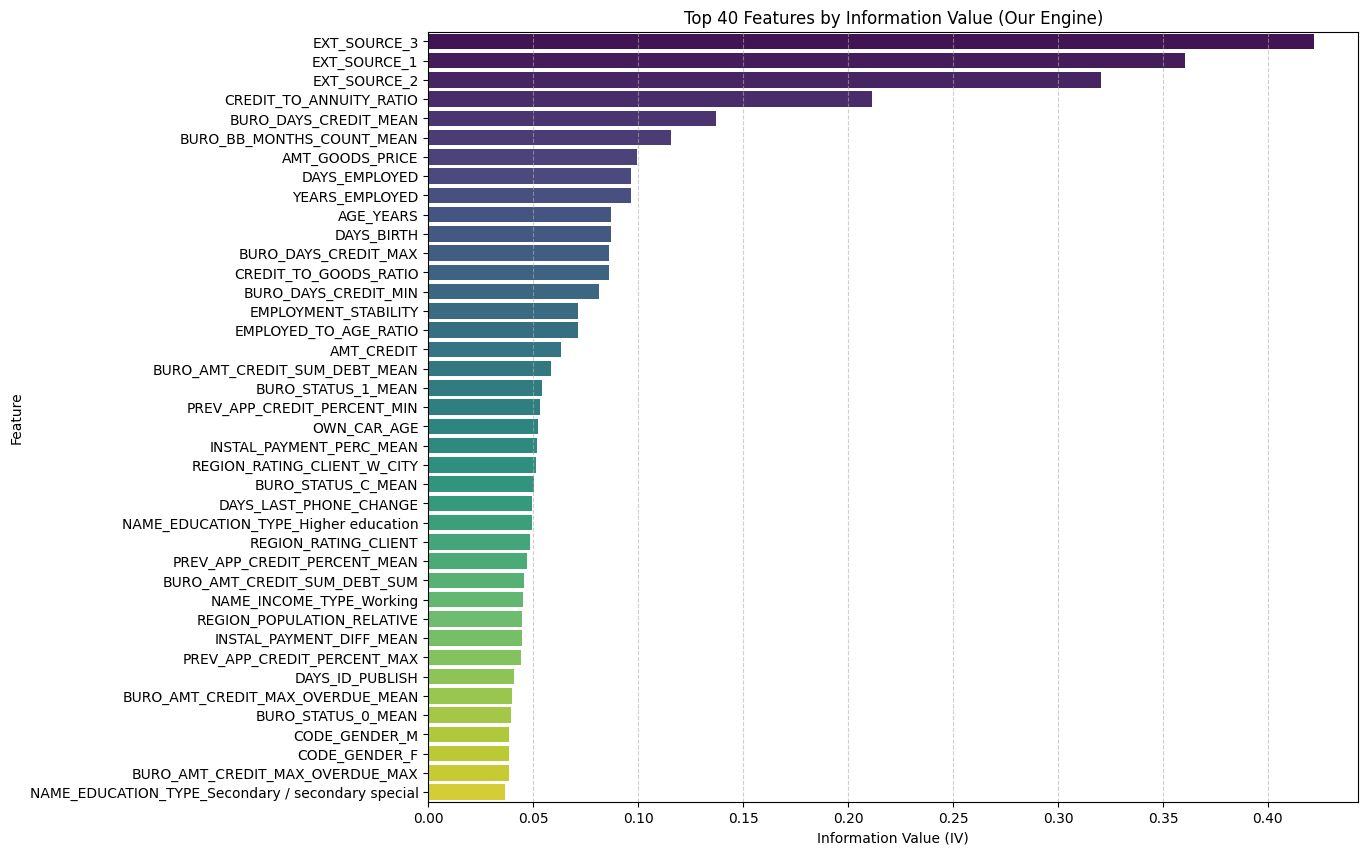


Found 81 features with IV > 0.02.
IV Calculation using our own engine - done in 50s

Analyzing multicollinearity...
Identified 38 features to remove: ['BURO_BB_MONTHS_COUNT_MEAN', 'YEARS_EMPLOYED', 'DAYS_BIRTH', 'BURO_DAYS_CREDIT_MIN', 'EMPLOYMENT_STABILITY', 'EMPLOYED_TO_AGE_RATIO', 'AMT_CREDIT', 'REGION_RATING_CLIENT', 'PREV_APP_CREDIT_PERCENT_MEAN', 'CODE_GENDER_F', 'BURO_AMT_CREDIT_MAX_OVERDUE_MAX', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'INSTAL_PAYMENT_DIFF_SUM', 'INSTAL_PAYMENT_PERC_VAR', 'FLOORSMAX_MEDI', 'AMT_ANNUITY', 'FLOORSMAX_MODE', 'ORGANIZATION_TYPE_XNA', 'FLAG_EMP_PHONE', 'LIVINGAREA_AVG', 'LIVINGAREA_MEDI', 'LIVINGAREA_MODE', 'FLOORSMIN_MEDI', 'FLOORSMIN_AVG', 'ELEVATORS_AVG', 'APARTMENTS_AVG', 'APARTMENTS_MEDI', 'ELEVATORS_MEDI', 'FLOORSMIN_MODE', 'APARTMENTS_MODE', 'EMERGENCYSTATE_MODE_nan', 'INSTAL_PAYMENT_DIFF_VAR', 'ELEVATORS_MODE', 'HOUSETYPE_MODE_block of flats', 'HOUSETYPE_MODE_nan', 'LIVINGAPARTMENTS_AVG', 'WALLSMATERIAL_MODE_nan', 'LIVINGAPARTME

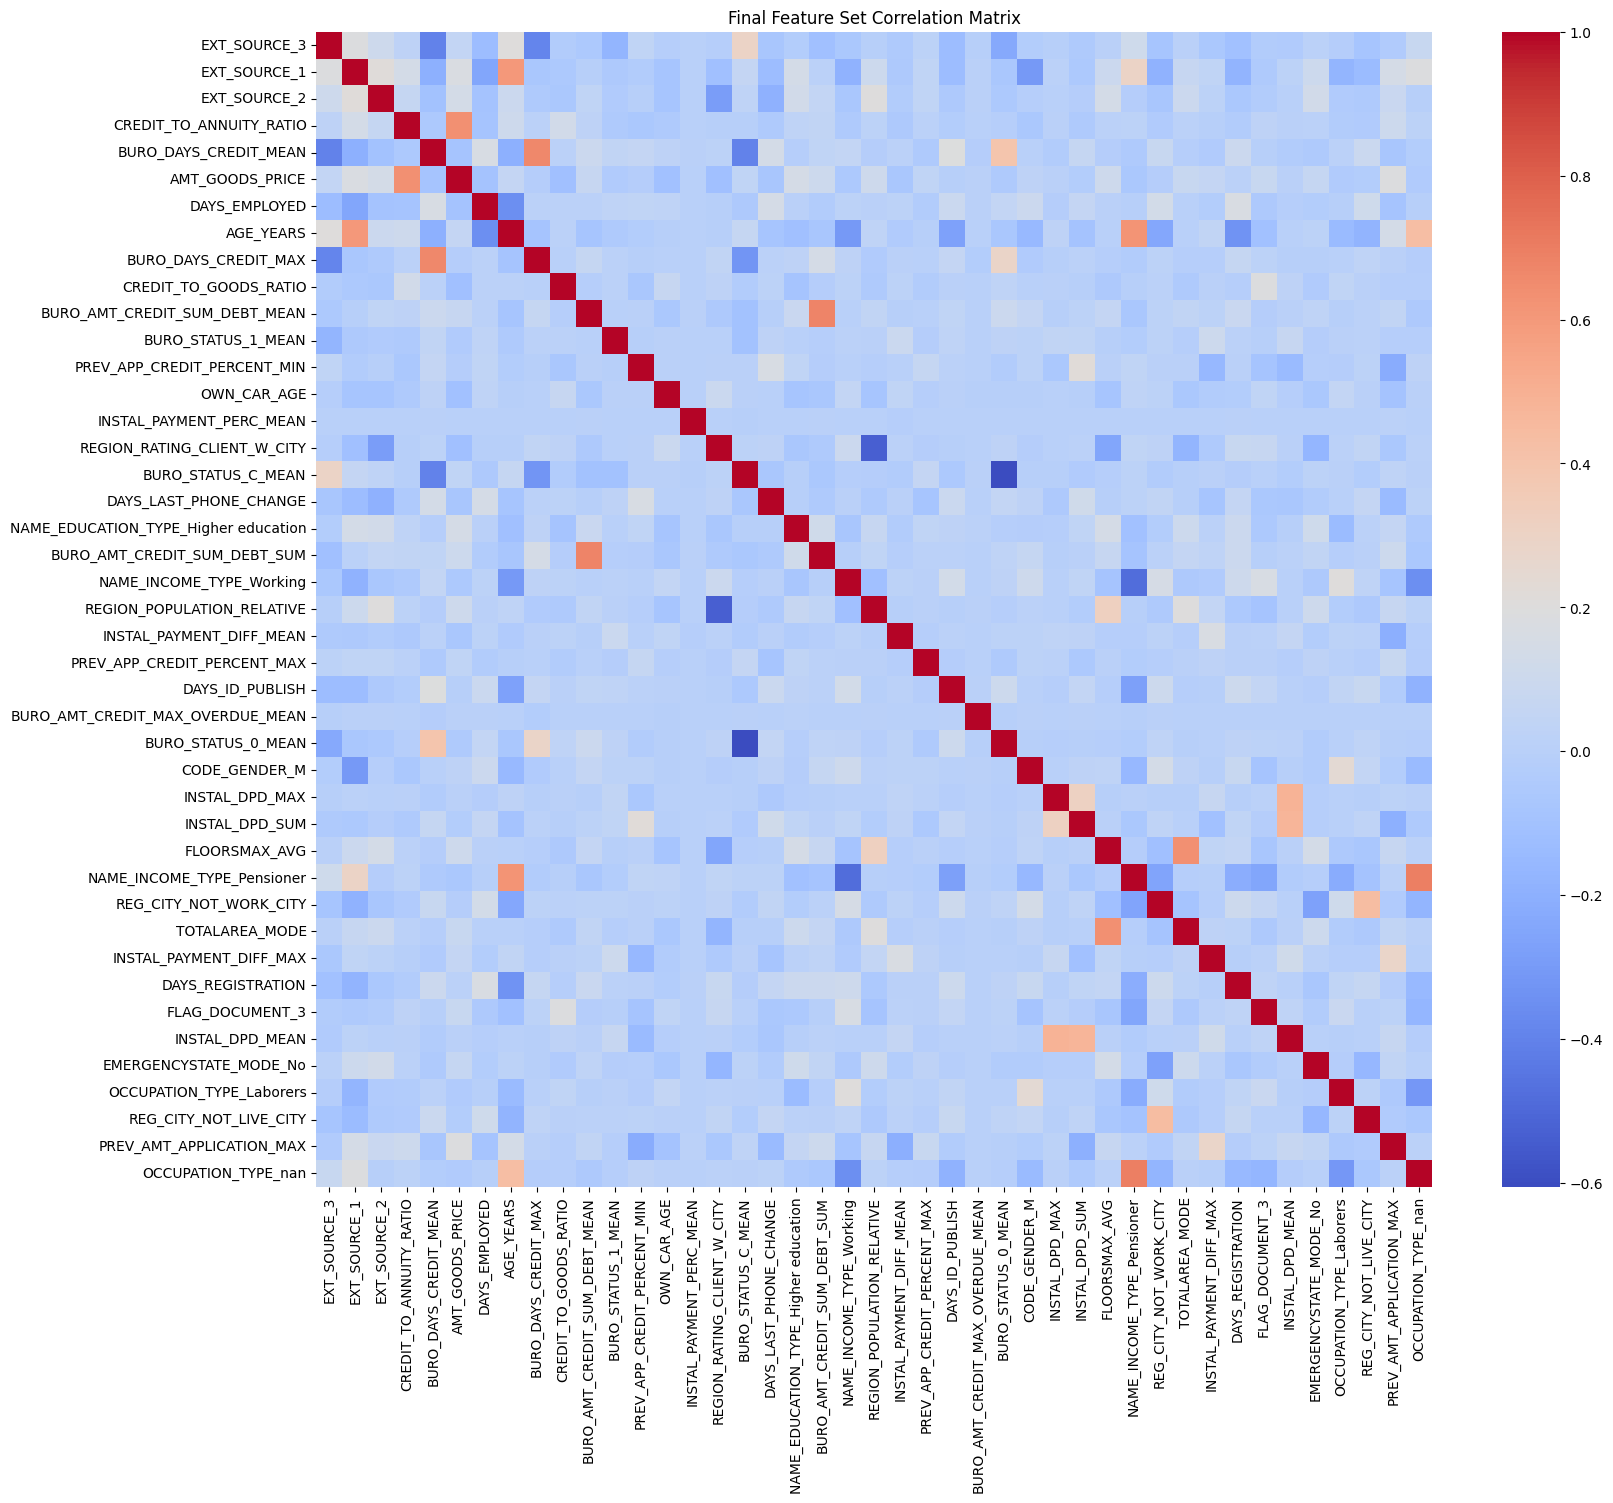

Multicollinearity Analysis - done in 24s

Saving final modeling dataset...
Final modeling dataset saved to: ..\processed_data\final_modeling_data.parquet
Shape of final dataset: (307511, 45)
--------------------------------------------------------------------------------
ARTICLE 2 (FEATURE ENGINEERING & SELECTION) IS COMPLETE.
--------------------------------------------------------------------------------


In [10]:
# ===================================================================================
# STAGE 4: FEATURE SELECTION (DISPLAY AND SAVE CHARTS)
# ===================================================================================

# --- 4.0: SETUP & LOAD DATA ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
import os

print("\nLoading master feature table for selection process...")
PROCESSED_DATA_PATH = os.path.join("..", "processed_data")
master_table_path = os.path.join(PROCESSED_DATA_PATH, "master_feature_table.parquet")
df = pd.read_parquet(master_table_path)

# --- THE CRITICAL FIX: Define the charts directory ---
CHARTS_PATH = os.path.join("..", "outputs", "charts")
os.makedirs(CHARTS_PATH, exist_ok=True)
print(f"Charts will be saved to: {os.path.abspath(CHARTS_PATH)}")

# --- 4.1: PRE-PROCESSING ---
print("\nPreparing data for feature selection...")
y = df['TARGET']
X = df.drop(columns=['SK_ID_CURR', 'TARGET'])
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, dummy_na=True)
X_encoded.replace([np.inf, -np.inf], np.nan, inplace=True)
print("Data prepared. All features are now numeric.")

# -----------------------------------------------------------------------------------
# (The library functions remain the same)
def get_optimal_bins(X: pd.Series, y: pd.Series, max_n_bins: int = 10, min_bin_size: float = 0.05) -> list:
    temp_df = pd.DataFrame({"X": X, "y": y}).dropna()
    tree_model = DecisionTreeClassifier(max_leaf_nodes=max_n_bins, min_samples_leaf=min_bin_size)
    tree_model.fit(temp_df['X'].values.reshape(-1, 1), temp_df['y'])
    splits = np.unique(tree_model.tree_.threshold[tree_model.tree_.feature != -2])
    return [-np.inf] + sorted(list(splits)) + [np.inf]

def calculate_woe_iv(df: pd.DataFrame, feature_name: str, target_name: str) -> tuple:
    temp_df = df.copy()
    grouped = temp_df.groupby(feature_name)[target_name].agg(['count', 'sum'])
    grouped.columns = ['Total', 'Bads']
    grouped['Goods'] = grouped['Total'] - grouped['Bads']
    grouped = grouped[grouped['Goods'] > 0]
    grouped = grouped[grouped['Bads'] > 0]
    grouped['% Goods'] = grouped['Goods'] / grouped['Goods'].sum()
    grouped['% Bads'] = grouped['Bads'] / grouped['Bads'].sum()
    grouped['WOE'] = np.log(grouped['% Goods'] / grouped['% Bads'])
    grouped['IV'] = (grouped['% Goods'] - grouped['% Bads']) * grouped['WOE']
    return grouped['WOE'].to_dict(), grouped['IV'].sum()

def get_iv_report(X: pd.DataFrame, y: pd.Series) -> pd.DataFrame:
    iv_scores = {}
    for col in X.columns:
        try:
            bins = get_optimal_bins(X[col], y)
            X_binned = pd.cut(X[col], bins=bins, labels=False, include_lowest=True)
            _, iv = calculate_woe_iv(pd.DataFrame({col: X_binned, 'target': y}), col, 'target')
            iv_scores[col] = iv
        except Exception as e:
            print(f"Could not process feature '{col}'. Skipping. Reason: {e}")
            iv_scores[col] = 0.0
    iv_df = pd.DataFrame.from_dict(iv_scores, orient='index', columns=['IV'])
    return iv_df.sort_values(by='IV', ascending=False)
# -----------------------------------------------------------------------------------

# --- EXECUTE THE WORKFLOW ---
with timer("IV Calculation using our own engine"):
    iv_report = get_iv_report(X_encoded, y)
    print("\nIV calculation complete.")
    
    # --- IV Plotting and Saving ---
    iv_to_plot = iv_report.head(40)
    plt.figure(figsize=(12, 10))
    sns.barplot(x=iv_to_plot['IV'], y=iv_to_plot.index, hue=iv_to_plot.index, palette="viridis", legend=False)
    plt.title('Top 40 Features by Information Value (Our Engine)')
    plt.xlabel('Information Value (IV)')
    plt.ylabel('Feature')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    
    # --- THE NEW CODE TO SAVE THE PLOT ---
    iv_plot_path = os.path.join(CHARTS_PATH, "iv_summary_plot.png")
    plt.savefig(iv_plot_path, dpi=300, bbox_inches='tight') # dpi=300 for high quality
    print(f"IV summary plot saved to: {iv_plot_path}")
    
    plt.show() # Display the plot in the notebook

    iv_threshold = 0.02
    selected_features_iv = iv_report[iv_report['IV'] > iv_threshold].index.tolist()
    print(f"\nFound {len(selected_features_iv)} features with IV > {iv_threshold}.")

with timer("Multicollinearity Analysis"):
    print("\nAnalyzing multicollinearity...")
    corr_matrix = X_encoded[selected_features_iv].corr()
    corr_threshold = 0.7
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column].abs() > corr_threshold)]
    print(f"Identified {len(to_drop)} features to remove: {to_drop}")
    final_features = [col for col in selected_features_iv if col not in to_drop]
    print(f"\nFinal feature set contains {len(final_features)} variables.")
    
    print("Displaying final correlation matrix...")
    final_corr_matrix = X_encoded[final_features].corr()
    plt.figure(figsize=(18, 15))
    sns.heatmap(final_corr_matrix, cmap='coolwarm', annot=False)
    plt.title('Final Feature Set Correlation Matrix')
    
    # --- THE NEW CODE TO SAVE THE PLOT ---
    corr_plot_path = os.path.join(CHARTS_PATH, "final_correlation_heatmap.png")
    plt.savefig(corr_plot_path, dpi=300, bbox_inches='tight')
    print(f"Correlation heatmap saved to: {corr_plot_path}")
    
    plt.show() # Display the plot in the notebook

# --- SAVE FINAL DATASET ---
final_modeling_data = pd.concat([df[['SK_ID_CURR', 'TARGET']], X_encoded[final_features]], axis=1)
final_data_path = os.path.join(PROCESSED_DATA_PATH, "final_modeling_data.parquet")
print(f"\nSaving final modeling dataset...")
final_modeling_data.to_parquet(final_data_path)
print(f"Final modeling dataset saved to: {final_data_path}")
print(f"Shape of final dataset: {final_modeling_data.shape}")
print("-" * 80)
print("ARTICLE 2 (FEATURE ENGINEERING & SELECTION) IS COMPLETE.")
print("-" * 80)